# EMToolKit Dashboard Example
## Multi-Instrument Method

### Import Statements

In [1]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))


import importlib, numpy as np
from sys import path
import astropy.units as u
import matplotlib.pyplot as plt

%matplotlib widget
# %matplotlib inline
# %matplotlib notebook


# plt.rcParams.update({'font.size': 18}) # Make the fonts in figures big enough for papers
# plt.rcParams.update({'figure.figsize':[27,15]})
plt.rcParams.update({'image.origin':'lower'})
np.set_printoptions(linewidth=128)

base_path = "../"
emtk_path = base_path + 'code/'
path.append(emtk_path)

import EMToolKit.EMToolKit as emtk

import EMToolKit
import EMToolKit.visualization
importlib.reload(EMToolKit)
importlib.reload(EMToolKit.visualization)
# importlib.reload(EMToolKit.visualization.dashboard)
import EMToolKit.EMToolKit as emtk
# from EMToolKit.visualization.dashboard import dashboard_figure
em_collection=0

In [2]:
# These flags tell the program not to recalculate the data if it has already been calculated
redownload = False
recalc_sparse = False
recalc_simple = False

### Download the Imagery

In [3]:
from EMToolKit.instruments.aia import download_sdo_data
from EMToolKit.instruments.xrt import download_xrt_data

date='2010/07/25 17:58:44'

# Download the data
aia_paths, sdo_data_dir = download_sdo_data(base_path, date, redownload=redownload)
xrt_paths, xrt_data_dir = download_xrt_data(base_path, date, redownload=redownload)
paths = aia_paths + xrt_paths




Found 6 aia images on disk.
Found 1 xrt images on disk.


### Load and Crop the Imagery

In [4]:
from EMToolKit.instruments.aia import load_from_paths, aia_wrapper
from EMToolKit.instruments.xrt import xrt_wrapper

xl, yl, = 240*u.arcsec, -525*u.arcsec # Left edge of FOV in arcseconds (relative to disk center)
                                      # Right edge of FOV in arcseconds (relative to disk center)
xlen, ylen  = 270*u.arcsec, 240*u.arcsec # X size of FOV in arcseconds # Y size of FOV in arcseconds


# Load the AIA Images ###
aiamaps = load_from_paths(aia_paths,xl=xl,yl=yl,dx=xlen,dy=ylen)
[maps,errs,trlogts,tresps] = aia_wrapper(aiamaps, temp_step_size=0.025)



# Load the XRT Image ###
    # We're loading these separately so that we can apply an offset to the XRT data -- there appears
    # to be a significant misalignment based on manual inspection and testing:
xrt_offsets = [-5*u.arcsec, -20*u.arcsec]
xrtmap = load_from_paths([[paths[0]],xrt_paths[0]],xl=xl+xrt_offsets[0],yl=yl+xrt_offsets[1],dx=xlen,dy=ylen)[1]
xrtmap.meta['crval1'] -= xrt_offsets[0].value
xrtmap.meta['crval2'] -= xrt_offsets[1].value
[xrtmaps,xrterrs,xrt_trlogts,xrt_tresps] = xrt_wrapper([xrtmap], temp_step_size=0.025)
# Append the XRT data to the AIA data
maps.append(xrtmaps[0])
errs.append(xrterrs[0])
trlogts.append(xrt_trlogts[0])
tresps.append(xrt_tresps[0])




In [5]:
# Normalizing the response functions makes them much easier for the solver to handle.
datmax_nominal = 1.0e4 # The nominal maximum of the data
overall_norm = datmax_nominal/np.max(np.array(tresps))
norms = np.max(np.array(tresps),axis=0)/np.max(np.array(tresps))/overall_norm

In [6]:
# Make data sequence from AIA & XRT data:
datasequence = emtk.em_data(maps,errs,trlogts,tresps)

# Create em_collection with AIA & XRT data:
em_collection = emtk.em_collection(datasequence)

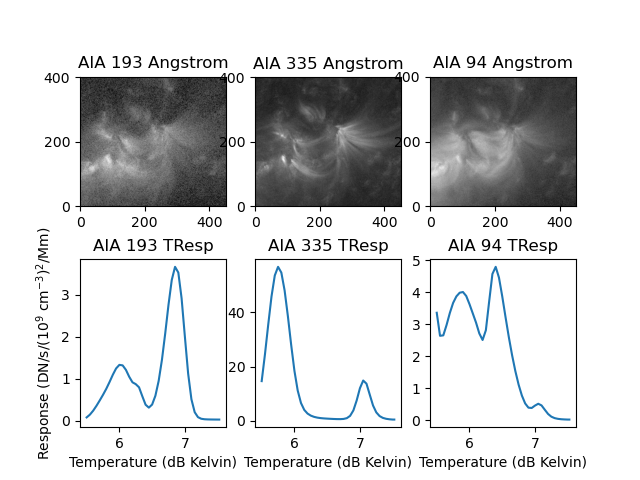

In [7]:
# Show some of the AIA channels and their temperature responses for illustration:
plt_emmax = 5.0e28
gfac = 1.0/2.2

fig, axs = plt.subplots(2, 3)
axs[0,0].imshow(np.clip(maps[1].data/np.max(tresps[1]),0,plt_emmax)**gfac,cmap=plt.get_cmap('gray'))
axs[0,0].set(title='AIA 193 Angstrom')
axs[1,0].plot(trlogts[1],tresps[1]/1.0e-27)
axs[1,0].set(title='AIA 193 TResp',xlabel='Temperature (dB Kelvin)',ylabel='Response (DN/s/(10$^9$ cm$^{-3})^2$/Mm)')

axs[0,1].imshow(np.clip(maps[2].data/np.max(tresps[2]),0,plt_emmax)**gfac,cmap=plt.get_cmap('gray'))
axs[0,1].set(title='AIA 335 Angstrom')
axs[1,1].plot(trlogts[2],tresps[2]/1.0e-27)
axs[1,1].set(title='AIA 335 TResp',xlabel='Temperature (dB Kelvin)')

axs[0,2].imshow(np.clip(maps[5].data/np.max(tresps[5]),0,plt_emmax)**gfac,cmap=plt.get_cmap('gray'))
axs[0,2].set(title='AIA 94 Angstrom')
axs[1,2].plot(trlogts[5],tresps[5]/1.0e-27)
axs[1,2].set(title='AIA 94 TResp',xlabel='Temperature (dB Kelvin)')

plt.show()

### Compute the Differential Emission Measure

In [8]:
from EMToolKit.algorithms.sparse_nlmap_dem_wrapper import sparse_nlmap_dem_wrapper
from EMToolKit.algorithms.multi_inst_dem_wrapper import multi_inst_dem_wrapper

# Make DEM sequence from the DEM and add it to the collection:
multi_out = multi_inst_dem_wrapper(datasequence, wrapargs={'norms':norms, 'overall_norm':overall_norm})
multi_em_demsequence = emtk.dem_model(*multi_out)
# Unpack the output
multi_coeffs, multi_logts, multi_bases, multi_coords, multi_algorithm, multi_em_wrapper = multi_out

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crln_obs,crlt_obs
 [sunpy.map.mapbase]
 14%|█▍        | 26476/189010 [00:10<00:58, 2763.52it/s]

In [ ]:
em_collection.add_model(multi_em_demsequence)

In [ ]:
# # print(type((collect)))
# # collect_dict = dict(collect)
# # print(collect_dict.keys())
# # print(collect_dict["data"])


# import asdf
# from ndcube import NDCollection

# # Your NDCollection
# my_ndcollection = collect

# # Create a new ASDF file
# with asdf.AsdfFile() as af:
#     # Iterate over items in the NDCollection and add them to the ASDF file
#     # print(my_ndcollection['models'])

#     af['data'] = []
#     af['meta_keys'] = []
#     af['meta_values'] = []
#     af['methods'] = []
#     for img in my_ndcollection['data']:
#         af['data'].append(img.data)
#         img_meta = copy.copy(img.meta)
#         # schema = img_meta["schema"]
#         # del img_meta["schema"]
#         # print (img_meta)
#         af['meta_keys'].append(img_meta.keys())
#         af['meta_values'].append(img_meta.values())

#     for mthd in my_ndcollection['models']:
#         af['methods'].append(mthd)
#         # af['method_meta'].append(([key, value] for key, value in mthd.meta.items()))

#     for key, ndcube in my_ndcollection.items():
#         # Here, 'key' can be used to uniquely identify each NDCube in the collection
#         # print (dir(ndcube))
#         # af[key] = {
#         #     'data': ,
#         #     # 'meta': ndcube.meta
#         # }
#         pass
#         # print(key)
#         # print((my_ndcollection[key]))
#     # Write the ASDF file to disk
#     af.write_to(f'{data_path}/my_ndcollection.fits')


# # print(collect_dict['data'][0].wcs)

In [ ]:
# multi_synthmaps = [em_collection.synthesize_map(map) for map in em_collection.data()]
# multi_synthdata = [map for map in multi_synthmaps]

In [ ]:
# def calc_resids(synthdata, em_collection):# Calculate the residuals and Chi squared:
# 	ndata = len(synthdata)
# 	resids = []
# 	datasequence = em_collection.data()
# 	chi2 = 0
# 	[nx,ny] = datasequence[0].data.shape
# 	for seq in datasequence: [nx,ny] = [np.min([seq.data.shape[0],nx]),np.min([seq.data.shape[1],ny])]
# 	for i in range(0,ndata):
# 		resids.append(((synthdata[i].data-datasequence[i].data)/datasequence[i].uncertainty.array)**2)
# 		chi2 += np.mean(resids[i])/ndata
# 	return resids, chi2

# #spars_resids, spars_chi2 = calc_resids(spars_synthdata,em_collection)
# #simpl_resids, simpl_chi2 = calc_resids(simpl_synthdata,em_collection)
# multi_resids, multi_chi2 = calc_resids(multi_synthdata,em_collection)
# print("Multi-instrument Chi squared = ",multi_chi2)
# #print('simple_reg_dem Chi squared = ',simpl_chi2, 'spars_em Chi squared = ',spars_chi2)

In [ ]:
# # Plot Residuals:
# fig = plt.figure(figsize=[20,12])
# plt.suptitle('Residuals for '+multi_algorithm)
# for i in range(0,7):
#     ax1 = fig.add_subplot(2,4,i+1)
#     ax1.imshow(multi_resids[i],vmin=0,vmax=5)
#     ax1.set(title=em_collection.data()[i].meta['channel'])

### Run the Dashboard

In [ ]:
# from __future__ import print_function

# Suppress specific SunpyMetadataWarning
import warnings
from sunpy.util.exceptions import SunpyMetadataWarning
warnings.filterwarnings("ignore", category=SunpyMetadataWarning)

# Get the most recent version from the tool kit:
from EMToolKit.visualization.dashboard import dashboard_object
importlib.reload(EMToolKit.visualization.dashboard)
from EMToolKit.visualization.dashboard import dashboard_object

# Create the dashboard:
dash = dashboard_object(em_collection)
dash.display()



In [ ]:
# importlib.reload(EMToolKit.visualization.dashboard)
# from EMToolKit.visualization.dashboard import dashboard_figure
# dash = dashboard_object(em_collection)

In [ ]:
# [nx,ny] = dash.emc.collection[dash.emc.collection['models'][0]][0].data.shape
# xpt=widgets.IntSlider(min=0, max=nx, value=10, step=1, description='xpt', continuous_update=False)
# ypt=widgets.IntSlider(min=0, max=ny, value=100, step=1, description='ypt', continuous_update=False)
# rtemp=widgets.FloatSlider(min=5, max=7, value=5.8, step=0.05, description='rtemp', continuous_update=False)
# gtemp=widgets.FloatSlider(min=5, max=7, value=6.1, step=0.05, description='gtemp', continuous_update=False)
# btemp=widgets.FloatSlider(min=5, max=7, value=6.4, step=0.05, description='btemp', continuous_update=False)
# sigma=widgets.FloatSlider(min=0.025, max=0.5, value=0.125, step=0.01, description='sigma', continuous_update=False)
# algorithm=widgets.Dropdown(options=dash.emc.collection['models'], description='algorithm', continuous_update=False)
# ui = widgets.HBox([xpt,ypt,rtemp,gtemp,btemp,sigma,algorithm])
# out = widgets.interactive_output(dash.widgwrap, {'xpt':xpt,'ypt':ypt,'rtemp':rtemp,'gtemp':gtemp,'btemp':btemp,'sigma':sigma,'algorithm':algorithm})
# display(ui,out)